import all libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md

read dataset from scv file

In [ ]:
dataset = pd.read_csv('CRYPTOCURRENCY_COINDESK_BTCUSD_NEW.csv')
for i in range(dataset.shape[0]):
  dataset['Close'][i] = float(dataset['Close'][i].replace(',',''))
dataset.head()


,Date,Close
0,10/11/2020,11350
1,10/12/2020,11564
2,10/13/2020,11437
3,10/14/2020,11396
4,10/15/2020,11544


replacing dates with indices and cleaning dataset

In [ ]:
dataset.drop(columns=['Date'], inplace=True)
dataset.rename(columns={"Close":"price"},inplace=True)
dataset.reset_index(inplace=True)
dataset.head()

,index,price
0,0,11350
1,1,11564
2,2,11437
3,3,11396
4,4,11544


splitting dataset for train and test

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0,axis=0)
train_dataset.sort_index(inplace=True)
test_dataset = dataset.drop(train_dataset.index)
print ("Number of total cases: ", str(dataset.shape[0]))
print ("Number of training cases: ", str(train_dataset.shape[0]))
print ("Number of testing cases: " , str(test_dataset.shape[0]))

Number of total cases:  366
Number of training cases:  293
Number of testing cases:  73


Normalize data to scale and avoid overflow

In [ ]:
# dataset_price = pd.DataFrame(dataset.pop('price'))
train_dataset_price = pd.DataFrame(train_dataset.pop('price'))
test_dataset_price = pd.DataFrame(test_dataset.pop('price'))
# train_dataset_price['price'] = train_dataset_price / dataset_price.mean(axis=0)
# test_dataset_price['price'] = train_dataset_price / dataset_price.mean(axis=0)

train_dataset_info = train_dataset.describe().transpose()
print(train_dataset_info)

def normalize(x):
  return (x - train_dataset_info['mean']) / train_dataset_info['std']

normalized_train_dataset= normalize(train_dataset)
normalized_test_dataset = normalize(test_dataset)
normalized_train_dataset.head()

       count       mean         std  min   25%    50%    75%    max
index  293.0  179.47099  105.347582  0.0  90.0  179.0  269.0  365.0


,index
0,-1.703608
1,-1.694116
2,-1.684623
3,-1.675131
4,-1.665639


In [ ]:
def update(x,t,w,b):
  degree = w.shape[0]
  n = x.shape[0]
  y = b
  for i in range (degree):
    y=y+w[i][0] * (x**(degree-i))

  cost = (1 / (2. * n)) * np.sum((y - t.values) ** 2)
  dw = np.zeros((degree,1))
  for i in range(degree):
    dw[i][0]  = (2 / n) * np.squeeze(np.dot((y - t.values).T, x ** (degree - i))[0])

  db = np.squeeze((1 / n) * np.sum(y- t.values))

  cost = np.squeeze(cost)

  d={"dw":dw,"db":db}
  return d,cost

In [ ]:
def find_params(x,t,w,b,alpha, epochs):

  for i in range(epochs):
    d,cost = update(x,t,w,b)
    dw = d["dw"]
    db = d["db"]
    w = w - alpha * dw
    b = b - alpha * db
    if i % 1000 == 0:
      print ("Cost after epochs %i: %f" %(i,cost))

  return w,b

In [ ]:
def model(train_x,train_t,test_x,test_t,alpha,epochs,degree):
  w = np.zeros((degree, 1))
  b = 0

  w,b = find_params(train_x,train_t,w,b,alpha,epochs)

  test_y=b
  train_y=b
  for i in range(degree):
    test_y =  w[i][0] * (test_x ** (degree - i)) + test_y
    train_y = w[i][0] * (train_x ** (degree - i)) + train_x

  train_error = np.mean((train_y - train_t.values) ** 2)
  test_error = np.mean(((test_y - test_t.values) ** 2))
  data={"w":w,"b":b,"test_error":test_error,"train_error":train_error}
  return data


In [ ]:
errors = []
min_error = {"degree": 0, "test_error": float('inf')}
for i in range(1,7):
  print("polynomial degree: " + str(i))
  data = model(normalized_train_dataset,train_dataset_price,normalized_test_dataset,test_dataset_price,alpha=0.005,epochs=3000, degree = i)

  errors.append({"degree": i, "train_error": data["train_error"], "test_error": data["test_error"], "w": data["w"], "b": data["b"]})
  # min_error["test_error"]= np.where(data["test_error"]<min_error["test_error)"],data["test_error"],min_error["test_error)"])
  if (data["test_error"] < min_error["test_error"]).bool():
    min_error["test_error"] = data["test_error"]
    min_error["degree"] = i

  print(min_error)



polynomial degree: 1
Cost after epochs 0: 837327501.064846
Cost after epochs 1000: 65763627.381601
Cost after epochs 2000: 65731038.963537
{'degree': 1, 'test_error': index    1.224197e+08
dtype: float64}
polynomial degree: 2
Cost after epochs 0: 837327501.064846
Cost after epochs 1000: 47947069.407789
Cost after epochs 2000: 40080269.377926
{'degree': 2, 'test_error': index    7.391535e+07
dtype: float64}
polynomial degree: 3
Cost after epochs 0: 837327501.064846
Cost after epochs 1000: 38758573.353890
Cost after epochs 2000: 30674296.297243
{'degree': 3, 'test_error': index    5.114554e+07
dtype: float64}
polynomial degree: 4
Cost after epochs 0: 837327501.064846
Cost after epochs 1000: 51006235.494458
Cost after epochs 2000: 31072347.298664
{'degree': 4, 'test_error': index    4.139188e+07
dtype: float64}
polynomial degree: 5
Cost after epochs 0: 837327501.064846
Cost after epochs 1000: 51013625.384844
Cost after epochs 2000: 29822654.800476
{'degree': 5, 'test_error': index    3.85

In [ ]:
errors[4]["w"]

array([[ -1664.89323578],
       [  3027.04106141],
       [  9981.02628771],
       [-14655.35015632],
       [ -3018.65841747]])

min_error degree :  5


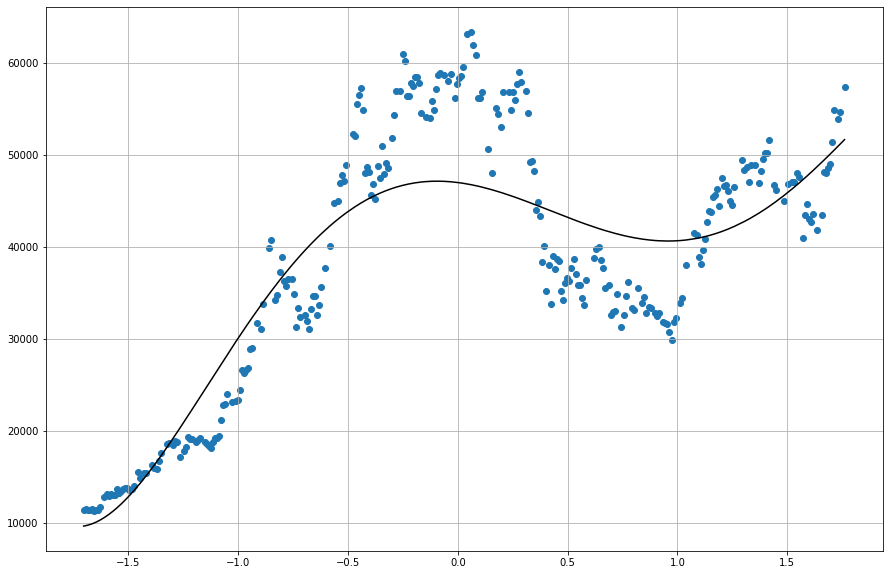

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
print("min_error degree : ",min_error["degree"])
ax.scatter(normalized_train_dataset['index'], train_dataset_price['price'])
y = errors[min_error["degree"] - 1]["b"]
for i in range(min_error["degree"]):
    y = y + errors[min_error["degree"] - 1]["w"][i] * (normalized_train_dataset['index'] ** (min_error["degree"] - i))
ax.plot(normalized_train_dataset['index'], y, color='black')
ax.grid(True)

plt.show()